In [1]:
import math
import nibabel as nib
from nilearn import plotting, image

import matplotlib.cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

from imagen_posthocloader import *
from plot_results_posthoc import *

%matplotlib inline

In [2]:
DATA_DIR = r"/ritter/share/data/IMAGEN"
SAVE_DIR = r"/ritter/share/jihoon/imagen_ml/posthoc_analysis/figures"
posthoc = IMAGEN_posthoc()

In [3]:
def get_top_features(tp_list=['FU3', 'FU2', 'BL'], threshold='2mean', viz=False):
    """ generate the dictionary of the mean SHAP of top features """
    ### helper funcs
    def get_featuretype_cnt(fs):
        dfc = pd.DataFrame()
        dfc.loc[0, 'Total'] = len(fs)
        dfc.loc[0, 'DTI'] = len([f for f in fs if 'DTI'==f.split('_')[0]])
        dfc.loc[0, 'T1w'] = len([f for f in fs if 'T1w'==f.split('_')[0]])
        dfc.loc[0, 'subcor'] = len([f for f in fs if 'subcor'==f.split('_')[1]])
        dfc.loc[0, 'subcor_area'] = len([f for f in fs if 'subcor'==f.split('_')[1] and 'mean'==f.split('_')[-1]])
        dfc.loc[0, 'subcor_vol'] = len([f for f in fs if 'subcor'==f.split('_')[1] and 'volume'==f.split('_')[-1]])
        dfc.loc[0, 'cor'] = len([f for f in fs if 'cor'==f.split('_')[1]])
        dfc.loc[0, 'cor_area'] = len([f for f in fs if 'cor'==f.split('_')[1] and 'area'==f.split('-')[-1]])
        dfc.loc[0, 'cor_curv'] = len([f for f in fs if 'cor'==f.split('_')[1] and 'curv' in f.split('-')[-1]])
        dfc.loc[0, 'cor_vol'] = len([f for f in fs if 'cor'==f.split('_')[1] and 'vol' in f.split('-')[-1]])
        dfc.loc[0, 'cor_thick'] = len([f for f in fs if 'cor'==f.split('_')[1] and 'thickness' in f.split('-')[-1]])
        dfc.loc[0, 'cor_foldind'] = len([f for f in fs if 'cor'==f.split('_')[1] and 'foldind' == f.split('-')[-1]])
        dfc = dfc.astype(int)
        return dfc.style.background_gradient(cmap='gray', vmin=0, vmax=len(top_features))

    shap_values_dict = {}
    
    for tp in tp_list:
        # load the mean|SHAP| value
        df = posthoc.read_SHAP(f'all_{tp}_SHAP.csv').set_index('Feature name').filter(regex="SVM-rbf._.* mean")
        df["all average"] = df.mean(axis=1)
        df = df.sort_values("all average", ascending=False)
        
        # Threshold
        if threshold=='2mean':
            thresh = 2 * df['all average'].mean()
        elif threshold=='mean':
            thresh = 1.1* df['all average'].mean()
        else:
            # first, convert the log-normal distribution to a normal distribution and then use std. dev. to set the cut-offs
            df2 = df.copy()
            for c in df2:
                df2[c] = np.log1p(df2[c].apply(lambda x: x*1000))/1000
            df2['lognorm mean'] = df2.mean(axis=1)
            df2['lognorm std'] = df2.std(axis=1)
            # set the threshold as mean|SHAP| + (x * std)
            if threshold=='95%':
                thresh = df2['lognorm average'].mean() + (1.96 * df2['lognorm std']) # 95%
            elif threshold=='99%':
                thresh = df2['lognorm average'].mean() + (2.58 * df2['lognorm std']) # 99%
            else: # threshold=='99.9%':
                thresh = df2['lognorm average'].mean() + (3.3 * df2['lognorm std'])  # 99.9%
        
            thresh = (math.exp(1000*thresh)-1)/1000

        # Top features
        df_top_features = df[df.apply(lambda x: x>=thresh).sum(axis=1) >= len(df.columns)-1] # .all(axis=1)]#
        top_features = df_top_features.index.to_list()
#         top_features = top_features.index.to_list()
#         top_features_dict.update({tp:top_features})
        
        # load the mean of the SHAP values of these top_features
        df_features_posSHAP = posthoc.read_SHAP(f'all_SVM-rbf_{tp}_POS.csv')[top_features]
        shap_values_dict.update({tp: dict(df_features_posSHAP.mean())})

        if viz == True:
            print(f'{"-"*36}\n    Analysis: {tp}   \n{"-"*36} \nThreshold >= {thresh} \n')
            if threshold==0:
                print(f'original: {new_thresh}')
            
            df_display = df_features_posSHAP.mean().to_frame().rename(columns={0: 'ave. feature value'})
            df_display['ave. SHAP value'] = df_top_features["all average"]
            display(df_display.sort_values(by='ave. SHAP value', ascending=False).style.bar(align='zero', color=['#d65f5f', '#5fba7d']))
            display(get_featuretype_cnt(top_features))
            display(df.head(22).style.background_gradient(vmin=thresh, cmap='PuBu_r').highlight_between(right=thresh, color='black'))
    return shap_values_dict

In [4]:
def save_colormap(cmap, viz=False):
    """Plot the colormap """
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    fig, ax = plt.subplots(1, figsize=(6, 1),
                           subplot_kw=dict(xticks=[], yticks=[]))
    ax.imshow([colors], extent=[0, 10, 0, 1])
    
    if viz == True:
        save_path = f"{SAVE_DIR}/cool.svg"
        if not os.path.isdir(os.path.dirnmae(save_path)):
            os.makedirs(os.path.dirnmae(save_path))
        fig.savefig(save_path)

In [5]:
_ = get_top_features(tp_list=['FU3', 'FU2', 'BL'], threshold='mean', viz=True)

------------------------------------
    Analysis: FU3   
------------------------------------ 
Threshold >= 0.004808501147329535 



,ave. feature value,ave. SHAP value
DTI_SCC_Average,-0.873530,0.014433
T1w_cor_lateraloccipital-rh-thickness,-0.677426,0.013378
T1w_subcor_CSF_mean,0.790300,0.013244
T1w_cor_caudalanteriorcingulate-lh-foldind,-0.613880,0.012721
T1w_subcor_Brain-Stem_mean,-0.594370,0.012637
T1w_subcor_Right-Amygdala_volume,0.664147,0.012564
T1w_cor_parahippocampal-rh-area,0.770722,0.012542
T1w_cor_cuneus-rh-thickness,-0.634456,0.012373
T1w_subcor_Right-Hippocampus_mean,0.623355,0.012200
T1w_subcor_CC_Anterior_volume,0.817868,0.011934


,Total,DTI,T1w,subcor,subcor_area,subcor_vol,cor,cor_area,cor_curv,cor_vol,cor_thick,cor_foldind
0,133,13,120,29,17,12,91,8,32,10,30,11


,SVM-rbf0_FU3 mean,SVM-rbf1_FU3 mean,SVM-rbf2_FU3 mean,SVM-rbf3_FU3 mean,SVM-rbf4_FU3 mean,SVM-rbf5_FU3 mean,SVM-rbf6_FU3 mean,all average
Feature name,,,,,,,,
DTI_SCC_Average,0.014127,0.013667,0.015137,0.015569,0.016892,0.014402,0.011235,0.014433
T1w_cor_lateraloccipital-rh-thickness,0.012873,0.011353,0.012539,0.014382,0.014206,0.017304,0.010990,0.013378
T1w_subcor_CSF_mean,0.015039,0.013902,0.014382,0.014225,0.014667,0.009284,0.011206,0.013244
T1w_cor_caudalanteriorcingulate-lh-foldind,0.011392,0.012186,0.014931,0.014588,0.011412,0.017284,0.007255,0.012721
T1w_subcor_Brain-Stem_mean,0.011784,0.010304,0.013049,0.014657,0.017569,0.010069,0.011029,0.012637
T1w_subcor_Right-Amygdala_volume,0.017804,0.011480,0.015137,0.012049,0.013353,0.008324,0.009804,0.012564
T1w_cor_parahippocampal-rh-area,0.012373,0.010137,0.014490,0.015745,0.010049,0.015265,0.009735,0.012542
T1w_cor_cuneus-rh-thickness,0.014275,0.012196,0.013461,0.011980,0.010049,0.012686,0.011961,0.012373
T1w_subcor_Right-Hippocampus_mean,0.015461,0.007725,0.010941,0.012794,0.013255,0.009765,0.015461,0.012200


------------------------------------
    Analysis: FU2   
------------------------------------ 
Threshold >= 0.005425947569570197 



,ave. feature value,ave. SHAP value
T1w_cor_caudalanteriorcingulate-rh-curvind,1.591756,0.019167
T1w_cor_caudalanteriorcingulate-lh-thicknessstd,-0.746035,0.017010
T1w_cor_cuneus-lh-curvind,0.462589,0.016139
T1w_cor_parstriangularis-rh-thicknessstd,-0.817190,0.015997
T1w_cor_pericalcarine-lh-curvind,0.010160,0.015952
T1w_cor_inferiortemporal-rh-thicknessstd,-0.854132,0.015746
T1w_subcor_CC_Anterior_mean,-0.642157,0.015396
T1w_cor_cuneus-rh-thickness,-0.725790,0.014955
T1w_cor_parsopercularis-lh-volume,-0.628446,0.014697
DTI_CST-L_Average,0.775736,0.014336


,Total,DTI,T1w,subcor,subcor_area,subcor_vol,cor,cor_area,cor_curv,cor_vol,cor_thick,cor_foldind
0,162,18,144,27,16,11,117,16,33,14,51,3


,SVM-rbf0_FU2 mean,SVM-rbf1_FU2 mean,SVM-rbf2_FU2 mean,SVM-rbf3_FU2 mean,SVM-rbf4_FU2 mean,SVM-rbf5_FU2 mean,SVM-rbf6_FU2 mean,all average
Feature name,,,,,,,,
T1w_cor_caudalanteriorcingulate-rh-curvind,0.018951,0.018882,0.018324,0.018314,0.019235,0.021304,0.019157,0.019167
T1w_cor_caudalanteriorcingulate-lh-thicknessstd,0.018490,0.013353,0.022441,0.017098,0.015265,0.017804,0.014618,0.017010
T1w_cor_cuneus-lh-curvind,0.017657,0.015353,0.015284,0.014755,0.016118,0.018186,0.015618,0.016139
T1w_cor_parstriangularis-rh-thicknessstd,0.011755,0.013353,0.018539,0.023647,0.022029,0.007843,0.014814,0.015997
T1w_cor_pericalcarine-lh-curvind,0.013755,0.017059,0.012667,0.017382,0.018863,0.015912,0.016029,0.015952
T1w_cor_inferiortemporal-rh-thicknessstd,0.014696,0.013696,0.023922,0.015373,0.019108,0.016951,0.006480,0.015746
T1w_subcor_CC_Anterior_mean,0.018255,0.015137,0.015118,0.012314,0.016137,0.017559,0.013255,0.015396
T1w_cor_cuneus-rh-thickness,0.010167,0.015471,0.018951,0.017706,0.015343,0.013118,0.013931,0.014955
T1w_cor_parsopercularis-lh-volume,0.016353,0.019078,0.018431,0.012941,0.018510,0.011588,0.005980,0.014697


------------------------------------
    Analysis: BL   
------------------------------------ 
Threshold >= 0.005461413884051484 



,ave. feature value,ave. SHAP value
T1w_subcor_Right-Pallidum_volume,0.775721,0.023244
T1w_cor_temporalpole-lh-volume,0.777293,0.021441
T1w_subcor_Right-Cerebellum-Cortex_volume,0.830438,0.020328
T1w_subcor_CC_Anterior_mean,-0.711844,0.018650
T1w_cor_rostralmiddlefrontal-lh-thicknessstd,-0.772379,0.018557
T1w_cor_parahippocampal-rh-area,0.823870,0.018141
T1w_cor_inferiorparietal-rh-volume,0.747201,0.018085
T1w_cor_lateraloccipital-lh-thickness,-0.733224,0.017517
T1w_cor_bankssts-rh-meancurv,-0.710600,0.016707
T1w_cor_parahippocampal-rh-volume,0.882348,0.016598


,Total,DTI,T1w,subcor,subcor_area,subcor_vol,cor,cor_area,cor_curv,cor_vol,cor_thick,cor_foldind
0,141,17,124,21,12,9,103,18,26,16,41,2


,SVM-rbf0_BL mean,SVM-rbf1_BL mean,SVM-rbf2_BL mean,SVM-rbf3_BL mean,SVM-rbf4_BL mean,SVM-rbf5_BL mean,SVM-rbf6_BL mean,all average
Feature name,,,,,,,,
T1w_subcor_Right-Pallidum_volume,0.020892,0.019804,0.018647,0.022333,0.025186,0.030343,0.025500,0.023244
T1w_cor_temporalpole-lh-volume,0.019167,0.018696,0.019637,0.020520,0.024520,0.023716,0.023833,0.021441
T1w_subcor_Right-Cerebellum-Cortex_volume,0.023157,0.023118,0.018931,0.017265,0.019608,0.022049,0.018167,0.020328
T1w_subcor_CC_Anterior_mean,0.020873,0.021353,0.012127,0.019637,0.023373,0.012922,0.020265,0.018650
T1w_cor_rostralmiddlefrontal-lh-thicknessstd,0.020049,0.016147,0.013402,0.020510,0.019088,0.019049,0.021657,0.018557
T1w_cor_parahippocampal-rh-area,0.023725,0.012539,0.014431,0.021775,0.016961,0.017618,0.019941,0.018141
T1w_cor_inferiorparietal-rh-volume,0.018373,0.018549,0.012686,0.020765,0.018510,0.019971,0.017745,0.018085
T1w_cor_lateraloccipital-lh-thickness,0.017627,0.014441,0.014373,0.025794,0.018529,0.018667,0.013186,0.017517
T1w_cor_bankssts-rh-meancurv,0.019931,0.019559,0.015196,0.013127,0.014980,0.014706,0.019451,0.016707


In [6]:
MNI_Atlas = r"/ritter/share/data/IMAGEN/posthoc/atlas/MNI152_T1_1mm_brain.nii.gz"
fu3 = r"/ritter/share/jihoon/imagen_ml/posthoc_analysis/results/IMAGEN_FU3_Feature_dm_ver05_roi.nii.gz"
fu2 = r"/ritter/share/jihoon/imagen_ml/posthoc_analysis/results/IMAGEN_FU2_Feature_dm_ver05_roi.nii.gz"
bl = r"/ritter/share/jihoon/imagen_ml/posthoc_analysis/results/IMAGEN_BL_Feature_dm_ver05_roi.nii.gz"
cm = mpl.cm.cool # mpl.cm.cool, mpl.cm.bwr, mpl.cm.seismic, colors.red_blue
mode = 'x' # 'x', 'y','z','Ortho', 'tiled'

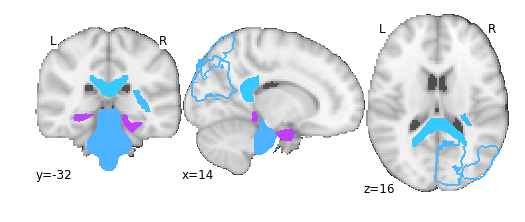

In [8]:
display = plotting.plot_anat(cmap='gray', bg_img=MNI_Atlas, black_bg=False, cut_coords=[14, -32, 16], draw_cross=None)
display.add_overlay(fu3, cmap=cm, vmin=-1.5, vmax=+1.5)
# display.savefig('figures/IMAGEN_Feature_ROI_FU3.svg')

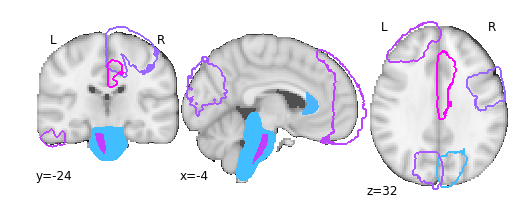

In [9]:
display = plotting.plot_anat(cmap='gray', bg_img=MNI_Atlas, cut_coords=[-4, -24, 32], draw_cross=None)
display.add_overlay(fu2, cmap=cm, vmin=-1.5, vmax=+1.5)
# display.savefig('figures/IMAGEN_Feature_ROI_FU2.svg')

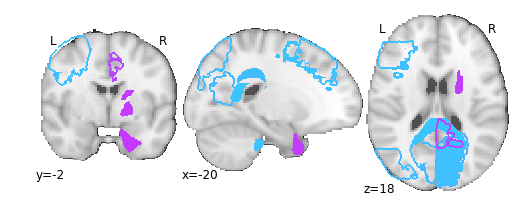

In [10]:
display = plotting.plot_anat(cmap='gray', bg_img=MNI_Atlas, black_bg=False, cut_coords=[-20, -2, 18], draw_cross=None)
display.add_overlay(bl, cmap=cm, vmin=-1.5, vmax=+1.5)
# display.savefig('figures/IMAGEN_Feature_ROI_BL.svg')

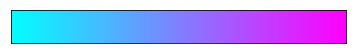

In [11]:
save_colormap(cm, viz=False)